# Notebook 5: Scaling Up Training

This notebook covers advanced training techniques for improving model performance:

1. **Curriculum Learning** - Start simple, increase difficulty gradually
2. **Data Augmentation** - Increase effective dataset size
3. **Learning Rate Scheduling** - Optimize training dynamics
4. **Architecture Comparison** - Find the best model for your task

These techniques help train better models without requiring more data or compute.


In [1]:
# Setup
import sys
sys.path.insert(0, '..')

import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import numpy as np

# TrajectoryForge imports
from physics.state import PhysicsState, SimulationConfig
from physics.fields import WindField, VortexField
from physics.simulator import simulate_positions_only

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")


JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## Part 1: Curriculum Learning

**Key Insight**: Training on easy examples first helps the model learn basic patterns before tackling complex cases.

### Why Curriculum Learning?

- **Faster convergence** - Model learns fundamentals quickly
- **Better generalization** - Avoids overfitting to hard cases
- **More stable training** - Gradual difficulty increase


In [2]:
from model.curriculum import (
    DifficultyLevel,
    DIFFICULTY_LEVELS,
    generate_sample_at_difficulty,
    CurriculumScheduler,
)

# View available difficulty levels
print("Available Difficulty Levels:")
print("=" * 50)
for name, level in DIFFICULTY_LEVELS.items():
    print(f"\n{name.upper()}")
    print(f"  Wind fields: {level.num_wind_fields}")
    print(f"  Vortex fields: {level.num_vortex_fields}")
    print(f"  Point forces: {level.num_point_forces}")
    print(f"  Strength range: {level.min_strength} - {level.max_strength}")
    print(f"  Trajectory length: {level.num_steps} steps")


Available Difficulty Levels:

TRIVIAL
  Wind fields: 1
  Vortex fields: 0
  Point forces: 0
  Strength range: 1.0 - 3.0
  Trajectory length: 50 steps

EASY
  Wind fields: 1
  Vortex fields: 0
  Point forces: 0
  Strength range: 2.0 - 5.0
  Trajectory length: 100 steps

MEDIUM
  Wind fields: 1
  Vortex fields: 1
  Point forces: 0
  Strength range: 3.0 - 10.0
  Trajectory length: 150 steps

HARD
  Wind fields: 2
  Vortex fields: 1
  Point forces: 1
  Strength range: 5.0 - 15.0
  Trajectory length: 200 steps

EXPERT
  Wind fields: 2
  Vortex fields: 2
  Point forces: 2
  Strength range: 5.0 - 20.0
  Trajectory length: 300 steps


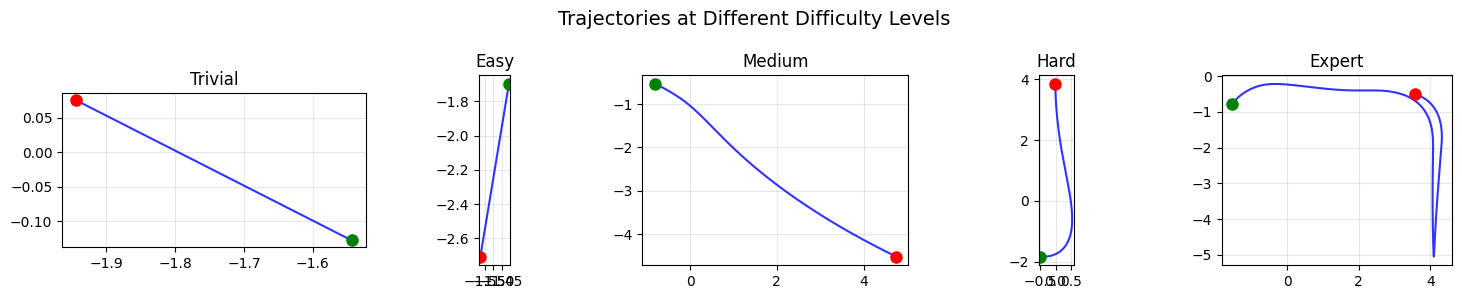

In [3]:
# Generate samples at different difficulty levels
key = random.PRNGKey(42)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for ax, (name, level) in zip(axes, DIFFICULTY_LEVELS.items()):
    key, subkey = random.split(key)
    sample = generate_sample_at_difficulty(subkey, level)
    
    traj = sample['trajectory']
    ax.plot(traj[:, 0], traj[:, 1], 'b-', linewidth=1.5, alpha=0.8)
    ax.plot(traj[0, 0], traj[0, 1], 'go', markersize=8, label='Start')
    ax.plot(traj[-1, 0], traj[-1, 1], 'ro', markersize=8, label='End')
    ax.set_title(f"{name.capitalize()}")
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.suptitle("Trajectories at Different Difficulty Levels", fontsize=14)
plt.tight_layout()
plt.show()


## Part 2: Data Augmentation

**Key Insight**: Transform existing data to create new training examples.

### Augmentation Types

- **Geometric**: Translation, rotation, scaling, flipping
- **Temporal**: Time warping, subsampling, reversal
- **Noise**: Gaussian noise, smooth noise, dropout


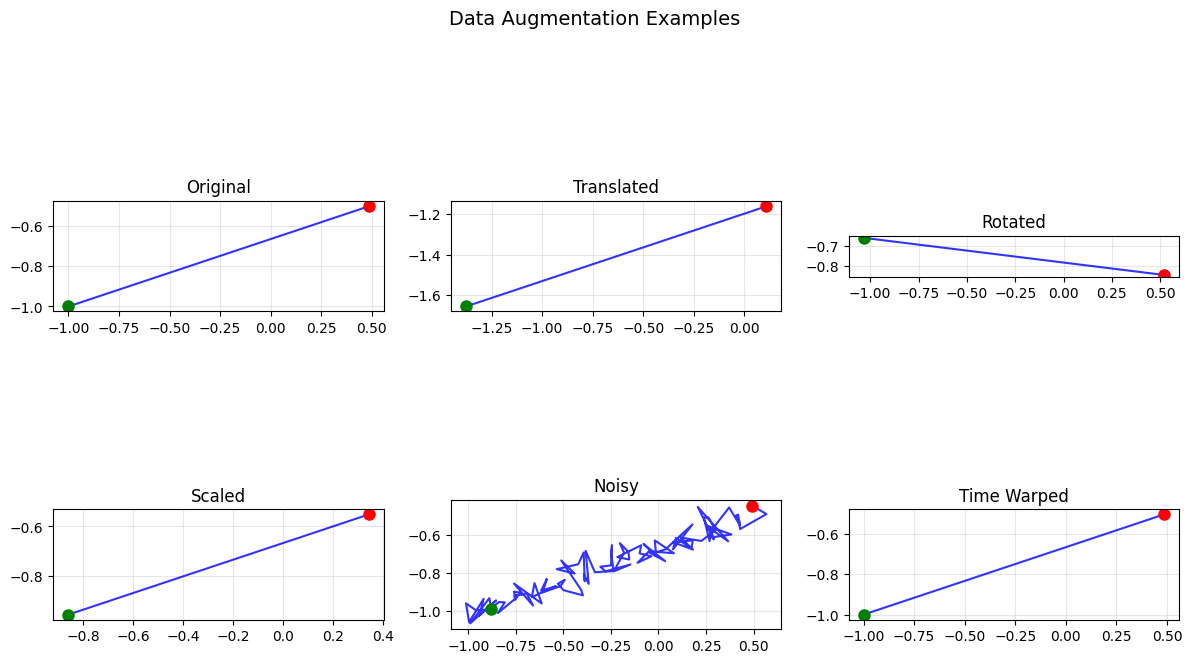

In [4]:
from model.augmentation import (
    augment_translate,
    augment_rotate,
    augment_scale,
    augment_flip,
    augment_gaussian_noise,
    augment_time_warp,
    AugmentationPipeline,
    create_strong_augmentation,
)

# Create a simple trajectory
config = SimulationConfig(dt=0.01, num_steps=100)
wind = WindField(
    center=jnp.array([1.0, 1.0]),
    size=jnp.array([2.0, 2.0]),
    direction=jnp.array([0.5, 0.5]),
    strength=5.0,
)
state = PhysicsState(position=jnp.array([-1.0, -1.0]), velocity=jnp.array([1.5, 0.5]), time=0.0)
original_traj = simulate_positions_only(state, [wind], config)

# Apply different augmentations
key = random.PRNGKey(123)
keys = random.split(key, 6)

augmentations = [
    ("Original", original_traj),
    ("Translated", augment_translate(keys[0], original_traj, max_offset=1.0)),
    ("Rotated", augment_rotate(keys[1], original_traj, max_angle=jnp.pi/4)),
    ("Scaled", augment_scale(keys[2], original_traj, min_scale=0.7, max_scale=1.3)),
    ("Noisy", augment_gaussian_noise(keys[3], original_traj, noise_std=0.05)),
    ("Time Warped", augment_time_warp(keys[4], original_traj, warp_strength=0.3)),
]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for ax, (name, traj) in zip(axes.flat, augmentations):
    ax.plot(traj[:, 0], traj[:, 1], 'b-', linewidth=1.5, alpha=0.8)
    ax.plot(traj[0, 0], traj[0, 1], 'go', markersize=8)
    ax.plot(traj[-1, 0], traj[-1, 1], 'ro', markersize=8)
    ax.set_title(name)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.suptitle("Data Augmentation Examples", fontsize=14)
plt.tight_layout()
plt.show()


## Part 3: Learning Rate Scheduling

**Key Insight**: Varying the learning rate during training can significantly improve results.

### Common Schedules

- **Warmup + Decay**: Start slow, ramp up, then decay
- **Cosine Annealing**: Smooth decay following cosine curve
- **One-Cycle**: Aggressive warmup and cooldown


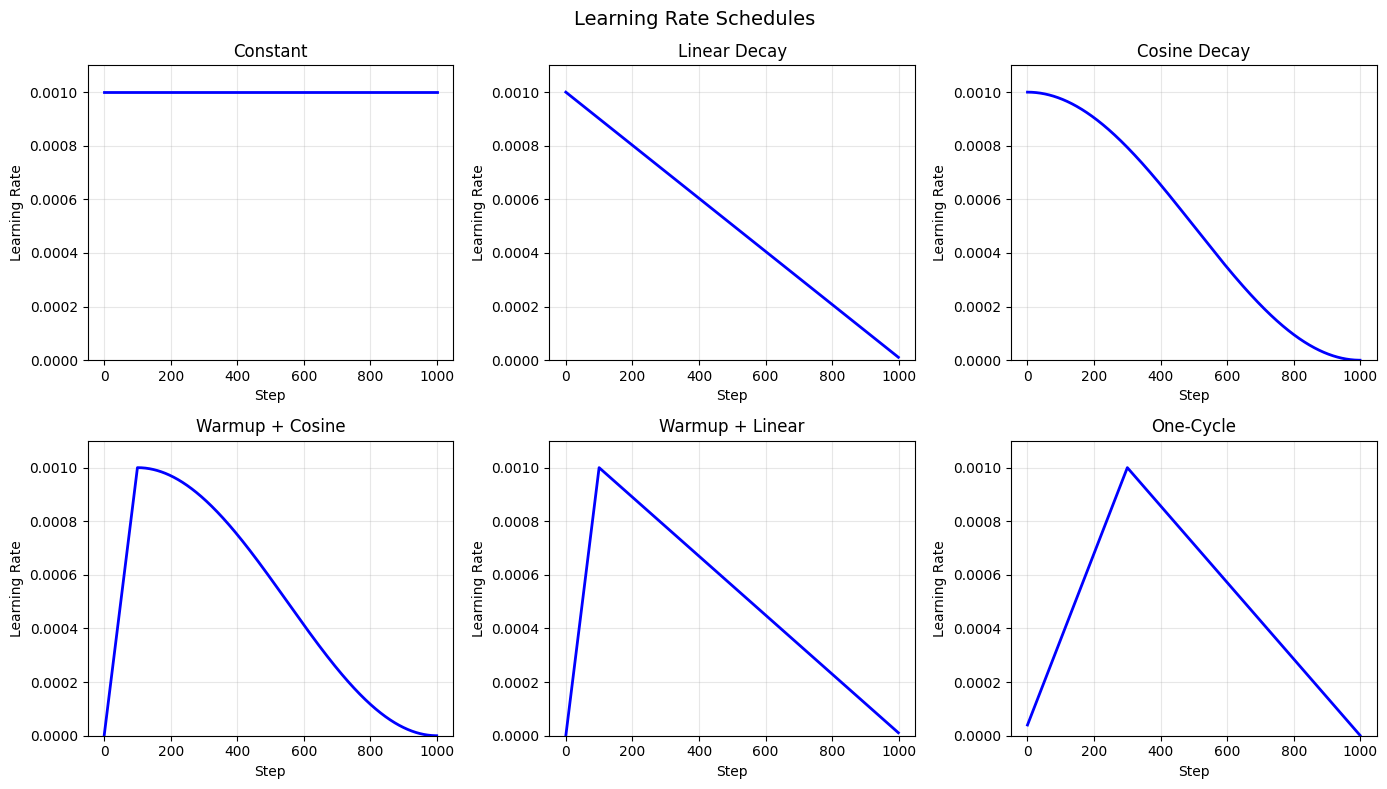

In [5]:
from model.scheduler import (
    constant_schedule,
    linear_decay_schedule,
    cosine_decay_schedule,
    warmup_cosine_decay_schedule,
    warmup_linear_decay_schedule,
    one_cycle_schedule,
    visualize_schedule,
)

total_steps = 1000
peak_lr = 1e-3

schedules = [
    ("Constant", constant_schedule(peak_lr)),
    ("Linear Decay", linear_decay_schedule(peak_lr, peak_lr * 0.01, total_steps)),
    ("Cosine Decay", cosine_decay_schedule(peak_lr, total_steps)),
    ("Warmup + Cosine", warmup_cosine_decay_schedule(peak_lr, 100, total_steps)),
    ("Warmup + Linear", warmup_linear_decay_schedule(peak_lr, peak_lr * 0.01, 100, total_steps)),
    ("One-Cycle", one_cycle_schedule(peak_lr, total_steps)),
]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for ax, (name, schedule) in zip(axes.flat, schedules):
    steps = list(range(total_steps))
    lrs = [float(schedule(s)) for s in steps]
    ax.plot(steps, lrs, 'b-', linewidth=2)
    ax.set_title(name)
    ax.set_xlabel('Step')
    ax.set_ylabel('Learning Rate')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, peak_lr * 1.1)

plt.suptitle("Learning Rate Schedules", fontsize=14)
plt.tight_layout()
plt.show()


## Part 4: Architecture Comparison

Different model architectures have different trade-offs:

- **Tiny/Small**: Fast training, good for simple problems
- **Medium**: Balanced, good default choice
- **Large**: High capacity, needs more data


In [6]:
from model.architectures import (
    MODEL_CONFIGS,
    describe_configs,
    create_model_from_config,
    ModelConfigBuilder,
)

# View all available configurations
print(describe_configs())


Available Model Configurations:

TINY
  Encoder: cnn
  Hidden dim: 32
  Latent dim: 16
  Max fields: wind=1, vortex=0, point=0
  Approx params: ~5K
  Training speed: very fast
  Minimal model for quick testing and debugging

SMALL
  Encoder: cnn
  Hidden dim: 64
  Latent dim: 32
  Max fields: wind=1, vortex=0, point=0
  Approx params: ~20K
  Training speed: fast
  Small CNN model for simple wind-only trajectories

MEDIUM
  Encoder: transformer
  Hidden dim: 128
  Latent dim: 64
  Max fields: wind=2, vortex=1, point=0
  Approx params: ~100K
  Training speed: medium
  Balanced transformer model for mixed wind/vortex fields

LARGE
  Encoder: transformer
  Hidden dim: 256
  Latent dim: 128
  Max fields: wind=3, vortex=2, point=2
  Approx params: ~500K
  Training speed: slow
  Large transformer for complex multi-field configurations

XLARGE
  Encoder: transformer
  Hidden dim: 512
  Latent dim: 256
  Max fields: wind=4, vortex=3, point=3
  Approx params: ~2M
  Training speed: very slow
  Ex


Actual Parameter Counts:
tiny      :     20,280 parameters
small     :     36,040 parameters
medium    :    664,021 parameters
large     :  2,709,930 parameters


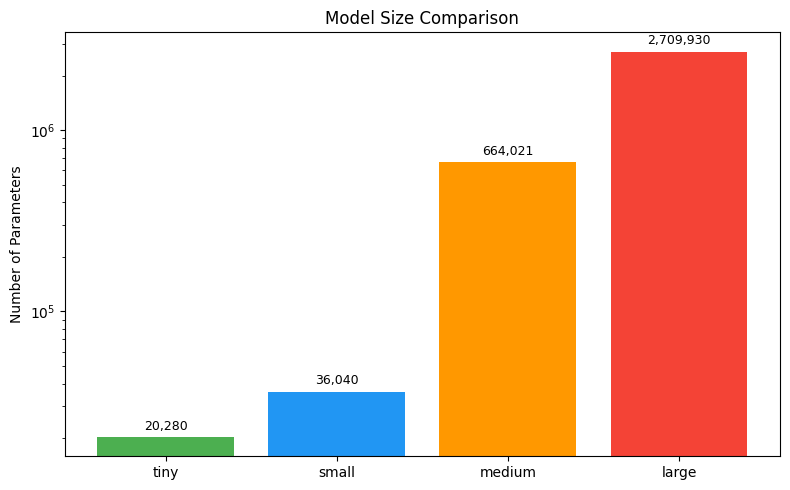

In [7]:
# Compare model sizes
def count_params(model, input_shape=(100, 2)):
    """Count parameters in a model."""
    key = random.PRNGKey(0)
    sample_input = jnp.ones((1,) + input_shape)
    variables = model.init(key, sample_input, training=False)
    return sum(p.size for p in jax.tree_util.tree_leaves(variables['params']))

print("\nActual Parameter Counts:")
print("=" * 40)

configs_to_test = ['tiny', 'small', 'medium', 'large']
param_counts = []

for config_name in configs_to_test:
    model = create_model_from_config(config_name)
    n_params = count_params(model)
    param_counts.append(n_params)
    print(f"{config_name:10s}: {n_params:>10,} parameters")

# Visualize
plt.figure(figsize=(8, 5))
plt.bar(configs_to_test, param_counts, color=['#4CAF50', '#2196F3', '#FF9800', '#F44336'])
plt.ylabel('Number of Parameters')
plt.title('Model Size Comparison')
plt.yscale('log')
for i, (name, count) in enumerate(zip(configs_to_test, param_counts)):
    plt.text(i, count * 1.1, f'{count:,}', ha='center', fontsize=9)
plt.tight_layout()
plt.show()


## Part 5: Putting It All Together

Here's how to combine these techniques for effective training.


In [ ]:
from model.training import Trainer, TrainingConfig, generate_training_sample
from model.curriculum import generate_sample_at_difficulty, DIFFICULTY_LEVELS, DifficultyLevel
from model.augmentation import AugmentationPipeline, augment_sample, create_strong_augmentation
from model.scheduler import create_adam_with_warmup
from model.architectures import create_model_from_config, ModelConfigBuilder
from physics.utils import resample_trajectory

# =============================================================================
# GPU + HIGH COMPUTE TRAINING SETUP
# =============================================================================

# Check if GPU is available
print("="*60)
print("HARDWARE CHECK")
print("="*60)
devices = jax.devices()
print(f"Available devices: {devices}")
if any('gpu' in str(d).lower() or 'cuda' in str(d).lower() for d in devices):
    print("✅ GPU DETECTED - Training will be fast!")
else:
    print("⚠️  CPU only - Consider using Google Colab for GPU access")
print("="*60 + "\n")

# =============================================================================
# CONFIGURATION - Adjust these based on your compute budget
# =============================================================================

# Set to True for full GPU training, False for quick CPU demo
USE_FULL_COMPUTE = True  # <-- SET THIS TO True FOR GPU TRAINING

if USE_FULL_COMPUTE:
    # FULL GPU SETTINGS (100x compute)
    MODEL_SIZE = 'large'           # Bigger model
    NUM_SAMPLES = 2000             # 10x more data
    AUGMENT_FACTOR = 3             # 3x augmentation
    NUM_EPOCHS = 200               # 4x more epochs
    BATCH_SIZE = 64                # Larger batches (GPU efficient)
    LEARNING_RATE = 1e-4           # Lower LR for stability
    print("🚀 FULL COMPUTE MODE: Large model, lots of data, many epochs")
else:
    # QUICK CPU SETTINGS (for testing)
    MODEL_SIZE = 'medium'
    NUM_SAMPLES = 200
    AUGMENT_FACTOR = 2
    NUM_EPOCHS = 50
    BATCH_SIZE = 32
    LEARNING_RATE = 3e-4
    print("💻 QUICK MODE: Medium model, moderate data")

# =============================================================================
# 1. CREATE MODEL
# =============================================================================

model = create_model_from_config(MODEL_SIZE)
print(f"\nModel: {MODEL_SIZE}")

# Count parameters
def count_params(model, input_shape=(100, 2)):
    key = random.PRNGKey(0)
    sample_input = jnp.ones((1,) + input_shape)
    variables = model.init(key, sample_input, training=False)
    return sum(p.size for p in jax.tree_util.tree_leaves(variables['params']))

n_params = count_params(model)
print(f"Parameters: {n_params:,}")

# =============================================================================
# 2. GENERATE TRAINING DATA
# =============================================================================

print(f"\nGenerating {NUM_SAMPLES} training samples...")
key = random.PRNGKey(42)
train_data = []

easy_level = DIFFICULTY_LEVELS['easy']

from tqdm import tqdm
for i in tqdm(range(NUM_SAMPLES), desc="Generating data"):
    key, subkey = random.split(key)
    sample = generate_sample_at_difficulty(subkey, easy_level)
    train_data.append(sample)

print(f"Generated {len(train_data)} samples (all {easy_level.num_steps} steps)")

# =============================================================================
# 3. AUGMENT DATA
# =============================================================================

print(f"\nAugmenting data ({AUGMENT_FACTOR}x per sample)...")
pipeline = create_strong_augmentation()
augmented_data = []

for sample in tqdm(train_data, desc="Augmenting"):
    augmented_data.append(sample)
    for _ in range(AUGMENT_FACTOR):
        key, subkey = random.split(key)
        aug_sample = augment_sample(subkey, sample, pipeline)
        augmented_data.append(aug_sample)

print(f"Total training samples: {len(augmented_data)}")


Using 'medium' model with transformer encoder
Generated 200 training samples (all 100 steps)
After augmentation: 600 samples (3x expansion)



TRAINING WITH IMPROVED SETUP
  Model: medium (transformer encoder)
  Training samples: 600
  Epochs: 50
  Batch size: 32
  Learning rate: 0.0003



Training: 100%|██████████| 50/50 [30:57<00:00, 37.15s/it, Epoch 45: train_loss=6.3854]


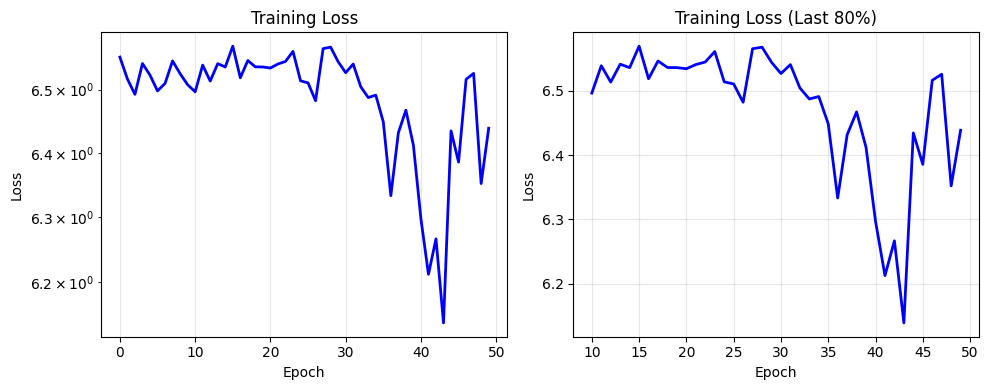


Final loss: 6.4386
Best loss: 6.1387


In [ ]:
# =============================================================================
# 4. TRAINING
# =============================================================================

config = TrainingConfig(
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    loss_type='physics',
    sim_steps=100,
    log_every=10,
)

trainer = Trainer(model, config, rng_seed=42)

# Print training summary
print("\n" + "="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print(f"  Model size:        {MODEL_SIZE} ({n_params:,} params)")
print(f"  Training samples:  {len(augmented_data):,}")
print(f"  Epochs:            {NUM_EPOCHS}")
print(f"  Batch size:        {BATCH_SIZE}")
print(f"  Learning rate:     {LEARNING_RATE}")
print(f"  Steps per epoch:   {len(augmented_data) // BATCH_SIZE}")
print(f"  Total steps:       {NUM_EPOCHS * (len(augmented_data) // BATCH_SIZE):,}")
print("="*60)

# Estimate training time
if USE_FULL_COMPUTE:
    print("\n⏱️  Estimated time: 10-30 min (GPU) or 2-4 hours (CPU)")
else:
    print("\n⏱️  Estimated time: 2-5 min (GPU) or 15-30 min (CPU)")

print("\n🚀 Starting training...\n")

history = trainer.train(augmented_data, verbose=True)

# =============================================================================
# 5. PLOT RESULTS
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Full training curve (log scale)
axes[0].plot(history['train_loss'], 'b-', linewidth=1.5, alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss (Log Scale)')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Last 50% of training (linear scale)
mid = len(history['train_loss']) // 2
axes[1].plot(range(mid, len(history['train_loss'])), 
             history['train_loss'][mid:], 'b-', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training Loss (Last 50%)')
axes[1].grid(True, alpha=0.3)

# Moving average
window = min(10, len(history['train_loss']) // 5)
if window > 1:
    smoothed = np.convolve(history['train_loss'], np.ones(window)/window, mode='valid')
    axes[2].plot(smoothed, 'b-', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss (Smoothed)')
    axes[2].set_title(f'Smoothed Loss (window={window})')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"  Final loss:  {history['train_loss'][-1]:.6f}")
print(f"  Best loss:   {min(history['train_loss']):.6f}")
print(f"  Improvement: {history['train_loss'][0] / history['train_loss'][-1]:.1f}x")
print("="*60)


## Summary

### Key Takeaways

1. **Curriculum Learning**: Start with simple examples, gradually increase difficulty
   - Faster convergence
   - Better generalization

2. **Data Augmentation**: Create variations of existing data
   - Effectively increases dataset size
   - Improves robustness

3. **Learning Rate Scheduling**: Vary LR during training
   - Warmup helps stability
   - Decay helps convergence

4. **Architecture Selection**: Match model capacity to problem complexity
   - Start small, scale up as needed
   - Use predefined configs for quick experiments

### Next Steps

- Try different curriculum strategies
- Experiment with augmentation strength
- Compare architectures on your specific task
- Move to Phase 5: Web Game!


In [17]:
# Generate test samples for evaluation - use EASY level to match training
test_samples = []
key = random.PRNGKey(999)  # Different seed for test data

# Use same difficulty as training for fair evaluation
easy_level = DIFFICULTY_LEVELS['easy']
for i in range(20):
    key, subkey = random.split(key)
    sample = generate_sample_at_difficulty(subkey, easy_level)
    test_samples.append(sample)

print(f"Generated {len(test_samples)} test samples for evaluation")


Generated 20 test samples for evaluation


In [18]:
# Function to get model prediction and simulate the predicted field
def predict_and_simulate(trainer, sample, sim_config):
    """
    Given a sample, predict the force field and simulate the resulting trajectory.
    
    Returns:
        predicted_trajectory: The trajectory from simulating the predicted field
        prediction: The raw model prediction
    """
    # Get model prediction
    trajectory = sample['trajectory']
    prediction = trainer.predict(trajectory)
    
    # Create wind field from prediction (using first wind field slot)
    predicted_wind = WindField(
        center=prediction.wind_centers[0, 0],
        size=prediction.wind_sizes[0, 0],
        direction=prediction.wind_directions[0, 0],
        strength=float(prediction.wind_strengths[0, 0]),
        softness=0.1,
    )
    
    # Simulate with predicted field
    init_state = PhysicsState(
        position=sample['initial_position'],
        velocity=sample['initial_velocity'],
        time=0.0,
    )
    
    predicted_traj = simulate_positions_only(init_state, [predicted_wind], sim_config)
    
    return predicted_traj, prediction

# Create simulation config matching training
sim_config = SimulationConfig(dt=0.01, num_steps=100)


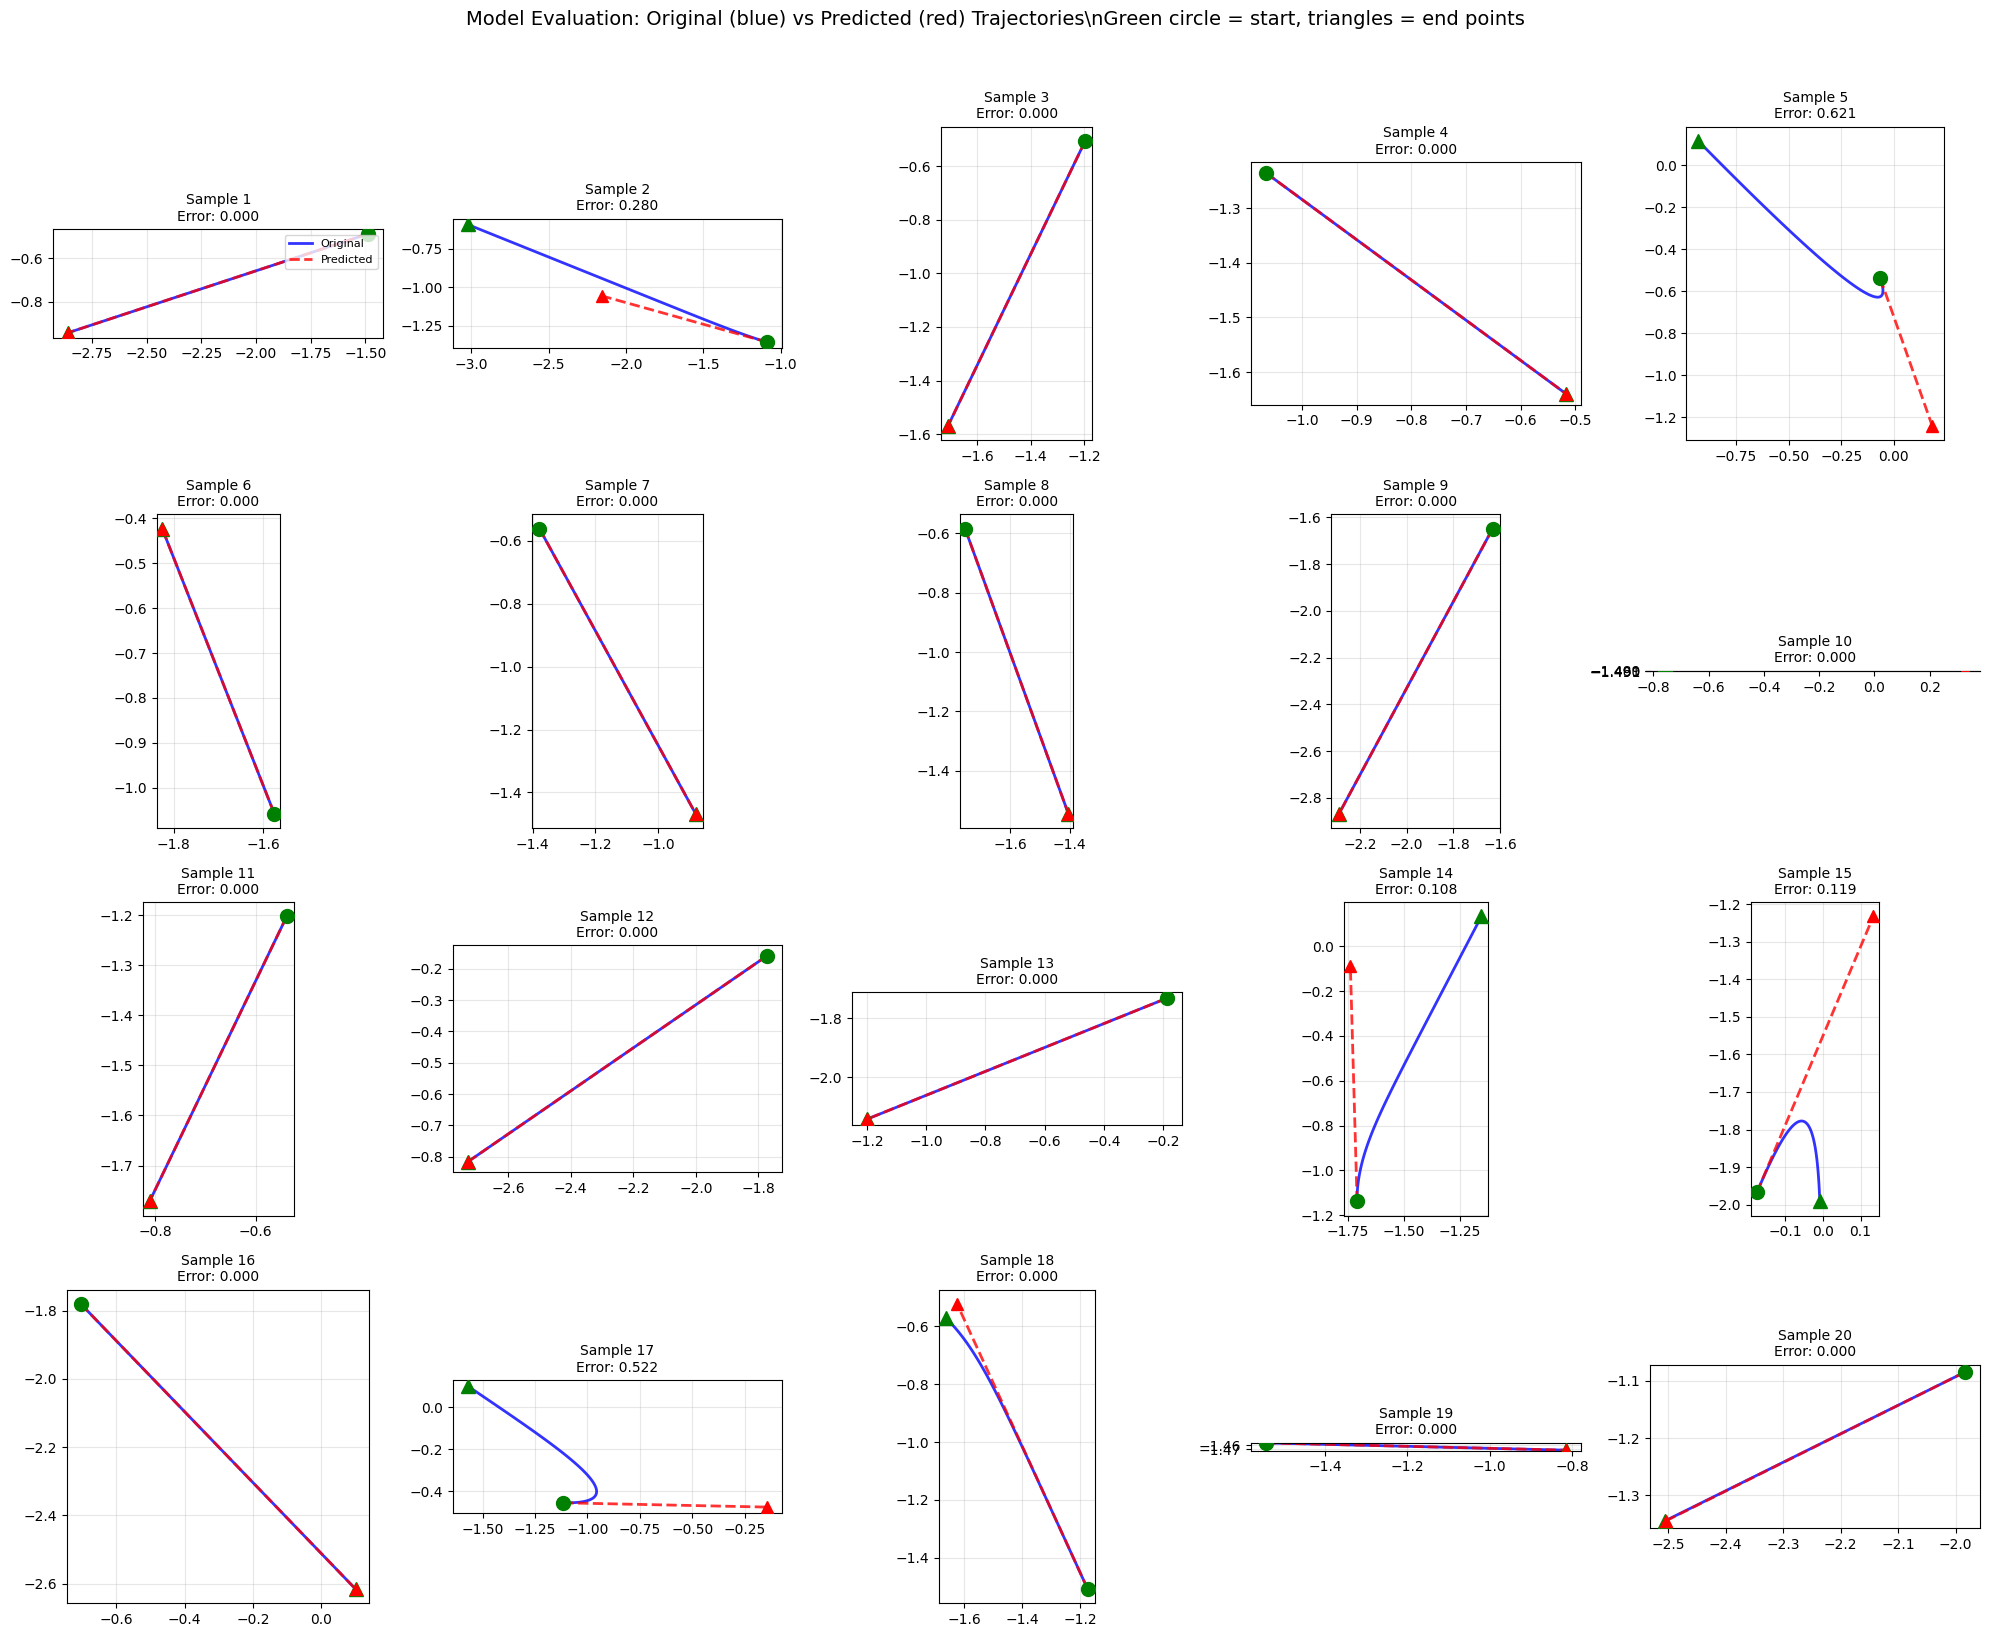


Error Statistics:
  Mean error: 0.0824
  Std error:  0.1768
  Min error:  0.0000
  Max error:  0.6205


: 

In [ ]:
# Visualize 20 samples: Original vs Predicted trajectories
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

errors = []

for i, sample in enumerate(test_samples):
    ax = axes[i]
    
    # Original trajectory
    orig_traj = sample['trajectory']
    
    # Get model prediction
    pred_traj, prediction = predict_and_simulate(trainer, sample, sim_config)
    
    # Compute error (mean squared distance)
    error = float(jnp.mean(jnp.sum((orig_traj - pred_traj) ** 2, axis=1)))
    errors.append(error)
    
    # Plot original trajectory
    ax.plot(orig_traj[:, 0], orig_traj[:, 1], 'b-', linewidth=2, alpha=0.8, label='Original')
    ax.plot(orig_traj[0, 0], orig_traj[0, 1], 'go', markersize=10, zorder=5)
    ax.plot(orig_traj[-1, 0], orig_traj[-1, 1], 'g^', markersize=10, zorder=5)
    
    # Plot predicted trajectory
    ax.plot(pred_traj[:, 0], pred_traj[:, 1], 'r--', linewidth=2, alpha=0.8, label='Predicted')
    ax.plot(pred_traj[-1, 0], pred_traj[-1, 1], 'r^', markersize=8, zorder=5)
    
    # Formatting
    ax.set_title(f'Sample {i+1}\nError: {error:.3f}', fontsize=10)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend(loc='upper right', fontsize=8)

plt.suptitle('Model Evaluation: Original (blue) vs Predicted (red) Trajectories\\n'
             'Green circle = start, triangles = end points', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nError Statistics:")
print(f"  Mean error: {np.mean(errors):.4f}")
print(f"  Std error:  {np.std(errors):.4f}")
print(f"  Min error:  {np.min(errors):.4f}")
print(f"  Max error:  {np.max(errors):.4f}")


In [ ]:
# Error distribution histogram
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(errors, bins=15, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(np.mean(errors), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.3f}')
axes[0].set_xlabel('Trajectory Error (MSE)')
axes[0].set_ylabel('Count')
axes[0].set_title('Error Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sorted errors (best to worst)
sorted_indices = np.argsort(errors)
axes[1].bar(range(len(errors)), [errors[i] for i in sorted_indices], color='steelblue', alpha=0.8)
axes[1].set_xlabel('Sample (sorted by error)')
axes[1].set_ylabel('Trajectory Error (MSE)')
axes[1].set_title('Errors Ranked Best to Worst')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Show best and worst predictions in detail
best_idx = sorted_indices[0]
worst_idx = sorted_indices[-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, idx, title in [(axes[0], best_idx, 'Best Prediction'), 
                        (axes[1], worst_idx, 'Worst Prediction')]:
    sample = test_samples[idx]
    orig_traj = sample['trajectory']
    pred_traj, prediction = predict_and_simulate(trainer, sample, sim_config)
    
    # Plot trajectories
    ax.plot(orig_traj[:, 0], orig_traj[:, 1], 'b-', linewidth=3, alpha=0.8, label='Original (Target)')
    ax.plot(pred_traj[:, 0], pred_traj[:, 1], 'r--', linewidth=3, alpha=0.8, label='Model Prediction')
    
    # Mark start and end
    ax.plot(orig_traj[0, 0], orig_traj[0, 1], 'go', markersize=15, zorder=5, label='Start')
    ax.plot(orig_traj[-1, 0], orig_traj[-1, 1], 'b^', markersize=12, zorder=5, label='Target End')
    ax.plot(pred_traj[-1, 0], pred_traj[-1, 1], 'r^', markersize=12, zorder=5, label='Predicted End')
    
    # Show predicted wind field parameters
    wind_center = prediction.wind_centers[0, 0]
    wind_strength = float(prediction.wind_strengths[0, 0])
    wind_dir = prediction.wind_directions[0, 0]
    
    # Draw wind field region
    from matplotlib.patches import Rectangle
    wind_size = prediction.wind_sizes[0, 0]
    rect = Rectangle(
        (wind_center[0] - wind_size[0], wind_center[1] - wind_size[1]),
        2 * wind_size[0], 2 * wind_size[1],
        fill=False, edgecolor='orange', linewidth=2, linestyle=':', label='Predicted Wind Region'
    )
    ax.add_patch(rect)
    
    # Draw wind direction arrow
    ax.arrow(float(wind_center[0]), float(wind_center[1]), 
             float(wind_dir[0]) * 0.5, float(wind_dir[1]) * 0.5,
             head_width=0.15, head_length=0.1, fc='orange', ec='orange', linewidth=2)
    
    ax.set_title(f'{title}\nError: {errors[idx]:.4f}\nWind strength: {wind_strength:.2f}', fontsize=12)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)

plt.suptitle('Detailed View: Best vs Worst Model Predictions', fontsize=14)
plt.tight_layout()
plt.show()


## Summary

### Key Takeaways

1. **Curriculum Learning**: Start with simple examples, gradually increase difficulty
   - Faster convergence
   - Better generalization

2. **Data Augmentation**: Create variations of existing data
   - Effectively increases dataset size
   - Improves robustness

3. **Learning Rate Scheduling**: Vary LR during training
   - Warmup helps stability
   - Decay helps convergence

4. **Architecture Selection**: Match model capacity to problem complexity
   - Start small, scale up as needed
   - Use predefined configs for quick experiments

5. **Model Evaluation**: Always visualize predictions to understand model behavior
   - Compare original vs predicted trajectories
   - Analyze error distribution to identify failure modes

### Next Steps

- Train longer with more data to improve predictions
- Try different curriculum strategies
- Experiment with augmentation strength
- Compare architectures on your specific task
- Move to Phase 5: Web Game!
